# Librerías

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-09-09 19:51:17.391844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:51:17.391881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:51:17.395660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:51:17.742925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [4]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-09-09 19:51:21.445667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-09 19:51:21.504193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-09 19:51:21.504347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Datos

In [5]:
## function to load images
def load_binary_images(file_names):  
    image = np.load(file_names).astype(np.float32)
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])   
    ## binariazar
    image = tf.where(image > 0.5, 1.0, 0.0)  
    return image

def load_images(file_names):
    image = np.load(file_names).astype(np.float32)
    #expand_dims
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])/255.0    
      
    return image

def min_max_scaler(ruta,image):
    ## load images in the path
    images = glob.glob(ruta + '/*.npy')
    images = sorted(images)
    ## load images
    images = [load_images(image) for image in images]
    ## min max scaler of thei image using the max and min of all images
    images = np.array(images)
    max_value = np.max(images)
    min_value = np.min(images)
    image = tf.math.abs((image - min_value)/(max_value - min_value))
    return image   

## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    #binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

## function to get geometric_attributes
def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')                

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter)]
        
        descriptors.append(descriptor)
        
    
    return descriptors

## function to get the middle image route in the folder
def get_middle_image(folder_route):
    ## get list of images
    images = glob.glob(folder_route + '/*.npy')
    ## order images
    images = sorted(images)
    ## get index of middle image
    if len(images) == 0:
        indx = -1
        middle_image = 'empty'
    else:
        indx = int(np.floor(len(images)/2))
        middle_image = images[indx]   
    
    return middle_image

In [6]:
## annotations to get nodule_features
annotations_cvs_4R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_4R.csv')
annotations_csv_3R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_3R.csv')
annotations = pd.concat([annotations_cvs_4R, annotations_csv_3R])
## drop malignancy = 3
annotations = annotations[annotations['malignancy'] != 3]
annotations

,patient_id,nodule_no,folder,malignancy,is_cancer,calcification,lobulation,texture,spiculation,subtlety,margin,intercept,slope
0,1,0,LICD-0001_NI000,5,True,6,3,5,5,5,4,-1024.0,1.0
1,3,1,LICD-0003_NI001,5,True,6,2,4,3,5,3,-1024.0,1.0
2,3,2,LICD-0003_NI002,4,True,6,2,5,2,4,4,-1024.0,1.0
3,3,3,LICD-0003_NI003,4,True,6,1,5,1,4,5,-1024.0,1.0
4,4,0,LICD-0004_NI000,1,False,3,1,5,1,3,5,-1024.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,353,0,LICD-0353_NI000,1,False,3,1,5,1,5,5,-1024.0,1.0
27,354,0,LICD-0354_NI000,1,False,3,1,5,1,5,5,0.0,1.0
28,390,6,LICD-0390_NI006,1,False,3,1,5,1,4,5,-1024.0,1.0
29,390,7,LICD-0390_NI007,1,False,3,1,5,1,3,5,-1024.0,1.0


In [7]:
## ruta dataset
rutas_images_npy = glob.glob('/data/Datasets/Nodules_ISBI/images/*/*.npy')

## order list by folder
rutas_images_npy = sorted(rutas_images_npy)

## get list of folders
folders = [ruta.split('/')[-2] for ruta in rutas_images_npy]
folders = np.unique(folders)

## build dataframe
rutas_images = []
rutas_masks = []
areas = []
perimetros = []
diametros = []
calsifications = []
spiculations = []
lobulations = []
sphericities = []
textures = []
margins = []

## cancer or not
labels = []
    
for folder in folders:
    ruta = '/data/Datasets/Nodules_ISBI/images/' + folder
    ruta_masc = '/data/Datasets/Nodules_ISBI/masks/' + folder
    
    ## load middle image route
    image_route = get_middle_image(ruta)
    name_image = image_route.split('/')[-1]
    mask_route = ruta_masc + '/' + name_image       
    
    if image_route != 'empty':    
        ## get attributes
        image = load_images(image_route)
        ## min-max scaler
        image = min_max_scaler(ruta, image)
        ## binary image
        binary_image = load_binary_images(mask_route)   
        ## get features of the image            
        features = annotations[annotations['folder'] == folder]
        if features.shape[0] != 0:     
            ## append rutas
            geometric_attributes = get_geometric_atributes([binary_image])[0]
            rutas_images.append(image_route)
            rutas_masks.append(mask_route)
            
            ## append attributes
            areas.append(geometric_attributes[0])
            perimetros.append(geometric_attributes[1])
            diametros.append(geometric_attributes[2])     
              
            malignancy = features['malignancy'].values[0]
            calsification = features['calcification'].values[0]
            spiculation = features['spiculation'].values[0]
            lobulation = features['lobulation'].values[0]
            texture = features['texture'].values[0]
            label = features['is_cancer'].values[0]
            margin = features['margin'].values[0]
            
            ## append featuresprint(features)
            calsifications.append(calsification)
            spiculations.append(spiculation)
            lobulations.append(lobulation)
            textures.append(texture)
            labels.append(label)
            margins.append(margin)


## build dataframe
df = pd.DataFrame()
df['ruta'] = rutas_images
df['mask'] = rutas_masks
df['area'] = areas
df['perimetro'] = perimetros
df['diametro'] = diametros
df['calsification'] = calsifications
df['spiculation'] = spiculations
df['lobulation'] = lobulations
df['texture'] = textures
df['margin'] = margins
df['label'] = labels

df

2024-09-09 19:51:37.447351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-09 19:51:37.447516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-09 19:51:37.447624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,ruta,mask,area,perimetro,diametro,calsification,spiculation,lobulation,texture,margin,label
0,/data/Datasets/Nodules_ISBI/images/LICD-0001_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0001_NI...,128.5,49.213203,12.791063,6,5,3,5,4,True
1,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,86.0,36.970562,10.464158,6,3,2,4,3,True
2,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,39.5,24.727922,7.091753,6,2,2,5,4,True
3,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,50.0,26.970562,7.978846,6,1,1,5,5,True
4,/data/Datasets/Nodules_ISBI/images/LICD-0004_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0004_NI...,10.5,14.242641,3.656366,3,1,1,5,5,False
...,...,...,...,...,...,...,...,...,...,...,...
528,/data/Datasets/Nodules_ISBI/images/LICD-1007_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1007_NI...,16.0,16.485281,4.513517,6,1,1,5,4,False
529,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,117.5,43.556349,12.231339,6,4,1,4,4,True
530,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,70.5,36.384776,9.474354,6,2,3,5,4,True
531,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,81.5,35.213203,10.186708,6,3,3,5,3,True


# Análisis de características

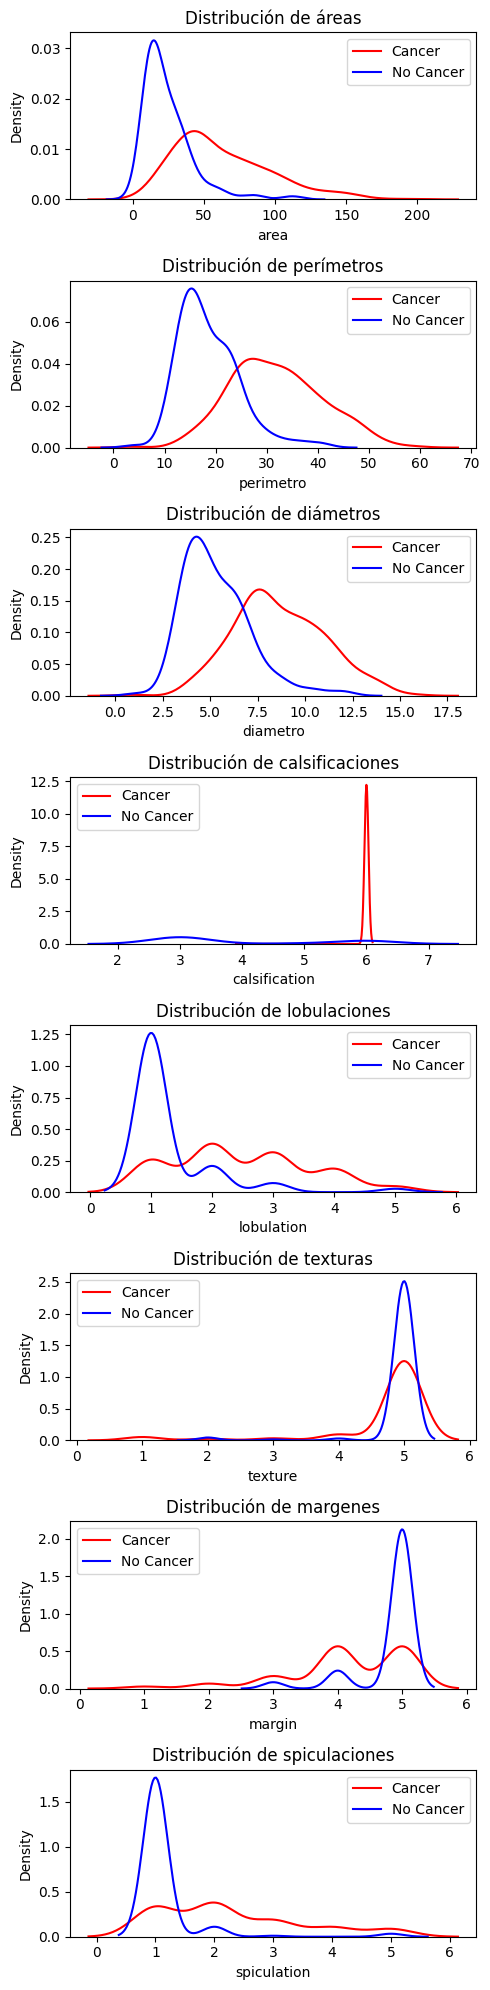

In [9]:
## Distribución de areas para positivos y negativos
cancer_areas = df[df['label'] == 'True']['area']
cancer_perimetros = df[df['label'] == 'True']['perimetro']
cancer_diametros = df[df['label'] == 'True']['diametro']
cancer_calsifications = df[df['label'] == 'True']['calsification']
cancer_lobulations = df[df['label'] == 'True']['lobulation']
cancer_texture = df[df['label'] == 'True']['texture']
cancer_margin = df[df['label'] == 'True']['margin']
cancer_spi = df[df['label'] == 'True']['spiculation']


no_cancer_areas = df[df['label'] == 'False']['area']
no_cancer_perimetros = df[df['label'] == 'False']['perimetro']
no_cancer_diametros = df[df['label'] == 'False']['diametro']
no_cancer_calsifications = df[df['label'] == 'False']['calsification']
no_cancer_lobulations = df[df['label'] == 'False']['lobulation']
no_cancer_texture = df[df['label'] == 'False']['texture']
no_cancer_margin = df[df['label'] == 'False']['margin']
no_cancer_spi = df[df['label'] == 'False']['spiculation']

## plot
plt.figure(figsize=(5,20))
plt.subplot(8,1,1)
sns.kdeplot(cancer_areas, color='red', label='Cancer')
sns.kdeplot(no_cancer_areas, color='blue', label='No Cancer')
plt.title('Distribución de áreas')
plt.legend()
plt.tight_layout()
plt.subplot(8,1,2)
sns.kdeplot(cancer_perimetros, color='red', label='Cancer')
sns.kdeplot(no_cancer_perimetros, color='blue', label='No Cancer')
plt.title('Distribución de perímetros')
plt.legend()
plt.tight_layout()
plt.subplot(8,1,3)
sns.kdeplot(cancer_diametros, color='red', label='Cancer')
sns.kdeplot(no_cancer_diametros, color='blue', label='No Cancer')
plt.title('Distribución de diámetros')
plt.legend()
plt.tight_layout()
plt.subplot(8,1,4)
sns.kdeplot(cancer_calsifications, color='red', label='Cancer')
sns.kdeplot(no_cancer_calsifications, color='blue', label='No Cancer')
plt.title('Distribución de calsificaciones')
plt.legend()
plt.tight_layout()
plt.subplot(8,1,5)
sns.kdeplot(cancer_lobulations, color='red', label='Cancer')
sns.kdeplot(no_cancer_lobulations, color='blue', label='No Cancer')
plt.title('Distribución de lobulaciones')
plt.legend()
plt.tight_layout()
plt.subplot(8,1,6)
sns.kdeplot(cancer_texture, color='red', label='Cancer')
sns.kdeplot(no_cancer_texture, color='blue', label='No Cancer')
plt.title('Distribución de texturas')
plt.legend()
plt.tight_layout()
plt.subplot(8,1,7)
sns.kdeplot(cancer_margin, color='red', label='Cancer')
sns.kdeplot(no_cancer_margin, color='blue', label='No Cancer')
plt.title('Distribución de margenes')
plt.legend()
plt.subplot(8,1,8)
sns.kdeplot(cancer_spi, color='red', label='Cancer')
sns.kdeplot(no_cancer_spi, color='blue', label='No Cancer')
plt.title('Distribución de spiculaciones')
plt.legend()
plt.tight_layout()
plt.show()

